In [106]:
#which price to use


# name as an indepnedt varibale (power transformer encoder) opposite of one encoder

# the best 底

# Tab choices

# Picture of the Pokemon

#subtype

#price

# Inital Preparation

In [107]:
#libaraies

import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import joblib
import requests


#20250527
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
import numpy as np


In [108]:
# Download latest version
path = kagglehub.dataset_download("adampq/pokemon-tcg-all-cards-1999-2023")

print("Path to dataset files:", path)

Path to dataset files: /Users/suzukikenta/.cache/kagglehub/datasets/adampq/pokemon-tcg-all-cards-1999-2023/versions/1


In [109]:
df = pd.read_csv(os.path.join(path, "pokemon-tcg-data-master 1999-2023.csv"))

In [110]:
api_key = os.getenv("POKEMON_API_KEY")
url = "https://api.pokemontcg.io/v2/cards"

all_cards = []

for i in range(1, 78):
    headers = {
        "X-Api-Key": api_key
    }
    params = {
        "pageSize": 250,
        "page": i
    }

    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()  # エラーがあれば例外を出す

    data = response.json()
    cards = data.get("data", [])
    all_cards.extend(cards)  # リストにカードを追加

print(f"Total cards fetched: {len(all_cards)}")

Total cards fetched: 18876


In [111]:
# Get prices from cardmarket

all_cards_1 = []
skip_count = 0

for i in range(18775):
    card = all_cards[i]
    card_id = card.get("id")

    # cardmarketとpricesの存在を確認
    cardmarket = card.get("cardmarket")
    if not cardmarket:
        skip_count += 1
        continue

    prices = cardmarket.get("prices")
    if not prices:
        skip_count += 1
        continue

    average_price = prices.get("averageSellPrice")
    if average_price is None:
        skip_count += 1
        continue

    # 問題なければ追加
    all_cards_1.append({
        "id": card_id,
        "market_price": average_price
    })

# ループの外でDataFrame作成
df_price_cardmarket = pd.DataFrame(all_cards_1)

print(f"Skipped {skip_count} cards due to missing or invalid cardmarket/prices info.")


Skipped 414 cards due to missing or invalid cardmarket/prices info.


In [112]:
# # Get prices from tcgplayer

# all_cards_1 = []
# skip_count = 0

# for i in range(18775):
#     card = all_cards[i]
#     card_id = card.get("id")

#     # cardmarketとpricesの存在を確認
#     tcgplayer = card.get("tcgplayer")
#     if not tcgplayer:
#         skip_count += 1
#         continue

#     prices = tcgplayer.get("prices")
#     if not prices:
#         skip_count += 1
#         continue

#     average_price = prices[list(prices.keys())[0]].get("market")
#     if average_price is None:
#         skip_count += 1
#         continue

#     # 問題なければ追加
#     all_cards_1.append({
#         "id": card_id,
#         "market_price": average_price
#     })

# # ループの外でDataFrame作成
# df_price_tcgplayer = pd.DataFrame(all_cards_1)

# print(f"Skipped {skip_count} cards due to missing or invalid cardmarket/prices info.")


In [113]:
# # Convert into csv files
df_price_cardmarket.to_csv("prices_cardmarket_20250527.csv", index=False)
# df_price_tcgplayer.to_csv("prices_tcgplayer_20250527.csv", index=False)

In [114]:
df_price = pd.read_csv("prices__20250527.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'prices__20250527.csv'

In [ ]:
df_price['market_price_log'] = np.log1p(df_price['market_price'])

In [ ]:
# Merge the price data with the main DataFrame
df = pd.merge(df, df_price, on='id', how='inner')

# Explatory Data Analysis (EDA)

In [ ]:
# The first 5 rows
df.head()

,id,set,series,publisher,generation,release_date,artist,name,set_num,types,...,rarity,flavorText,nationalPokedexNumbers,legalities,resistances,rules,regulationMark,ancientTrait,market_price,market_price_log
0,base1-1,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Alakazam,1,['Psychic'],...,Rare Holo,Its brain can outperform a supercomputer. Its ...,[65],{'unlimited': 'Legal'},NaN,NaN,NaN,NaN,60.71,4.122446
1,base1-2,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Blastoise,2,['Water'],...,Rare Holo,A brutal Pokémon with pressurized water jets o...,[9],{'unlimited': 'Legal'},NaN,NaN,NaN,NaN,163.30,5.101694
2,base1-3,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Chansey,3,['Colorless'],...,Rare Holo,A rare and elusive Pokémon that is said to bri...,[113],{'unlimited': 'Legal'},"[{'type': 'Psychic', 'value': '-30'}]",NaN,NaN,NaN,36.44,3.622740
3,base1-4,Base,Base,WOTC,First,1/9/1999,Mitsuhiro Arita,Charizard,4,['Fire'],...,Rare Holo,Spits fire that is hot enough to melt boulders...,[6],{'unlimited': 'Legal'},"[{'type': 'Fighting', 'value': '-30'}]",NaN,NaN,NaN,475.08,6.165586
4,base1-5,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Clefairy,5,['Colorless'],...,Rare Holo,Its magical and cute appeal has many admirers....,[35],{'unlimited': 'Legal'},"[{'type': 'Psychic', 'value': '-30'}]",NaN,NaN,NaN,30.83,3.460409


In [ ]:
# The last 5 rows
df.tail()

,id,set,series,publisher,generation,release_date,artist,name,set_num,types,...,rarity,flavorText,nationalPokedexNumbers,legalities,resistances,rules,regulationMark,ancientTrait,market_price,market_price_log
16877,sv4-262,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,takuyoa,Roaring Moon ex,262,['Darkness'],...,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,['Pokémon ex rule: When your Pokémon ex is Kno...,G,NaN,6.03,1.950187
16878,sv4-263,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,Oswaldo KATO,Beach Court,263,NaN,...,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""The Retreat Cost of each Basic Pokémon in pl...",G,NaN,3.34,1.467874
16879,sv4-264,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,Toyste Beach,Counter Catcher,264,NaN,...,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""You can use this card only if you have more ...",G,NaN,9.15,2.317474
16880,sv4-265,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,Toyste Beach,Luxurious Cape,265,NaN,...,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""If the Pokémon this card is attached to does...",G,NaN,5.19,1.822935
16881,sv4-266,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,NaN,Reversal Energy,266,NaN,...,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""As long as this card is attached to a Pokémo...",G,NaN,5.03,1.796747


In [ ]:
# Basics
df.info()
df.describe()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16882 entries, 0 to 16881
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      16882 non-null  object 
 1   set                     16882 non-null  object 
 2   series                  16882 non-null  object 
 3   publisher               16882 non-null  object 
 4   generation              16882 non-null  object 
 5   release_date            16882 non-null  object 
 6   artist                  16684 non-null  object 
 7   name                    16882 non-null  object 
 8   set_num                 16882 non-null  object 
 9   types                   14306 non-null  object 
 10  supertype               16882 non-null  object 
 11  subtypes                16708 non-null  object 
 12  level                   2398 non-null   object 
 13  hp                      14342 non-null  float64
 14  evolvesFrom             6107 non-null 

id                            0
set                           0
series                        0
publisher                     0
generation                    0
release_date                  0
artist                      198
name                          0
set_num                       0
types                      2576
supertype                     0
subtypes                    174
level                     14484
hp                         2540
evolvesFrom               10775
evolvesTo                 11187
abilities                 13507
attacks                    2567
weaknesses                 2977
retreatCost                3388
convertedRetreatCost       3388
rarity                      193
flavorText                 7256
nationalPokedexNumbers     2678
legalities                    0
resistances               12661
rules                     11790
regulationMark            11956
ancientTrait              16823
market_price                  0
market_price_log              0
dtype: i

## Inital Elimination

In [ ]:
# Drop Non-Pokoemon Card
df = df[df["supertype"] == "Pokémon"]

In [ ]:
# Drop Columns with Too Many NaNs
def drop_columns_with_too_many_nans(df, threshold=0.80):
    # Calculate the threshold for NaN values
    nan_threshold = len(df) * threshold
    # Drop columns with NaN values above the threshold
    df_cleaned = df.dropna(thresh=nan_threshold, axis=1)
    return df_cleaned
df = drop_columns_with_too_many_nans(df)

In [ ]:
# Rows
print("Number of rows:", len(df))

Number of rows: 14303


# Feature Selection(Only columns you absolutely cannot use)

In [ ]:
# Valid Columns
df.columns

Index(['id', 'set', 'series', 'publisher', 'generation', 'release_date',
       'artist', 'name', 'set_num', 'types', 'supertype', 'subtypes', 'hp',
       'attacks', 'weaknesses', 'retreatCost', 'convertedRetreatCost',
       'rarity', 'nationalPokedexNumbers', 'legalities', 'market_price',
       'market_price_log'],
      dtype='object')

## Set

In [ ]:
# how many sets
print("Number of unique sets:", df['set'].nunique())

Number of unique sets: 146


In [ ]:
# Display full value counts
print(df["set"].value_counts())

set
SWSH Black Star Promos        286
SM Black Star Promos          245
Fusion Strike                 245
Paldea Evolved                238
Cosmic Eclipse                228
                             ... 
McDonald's Collection 2012     12
POP Series 4                   12
POP Series 5                   10
Best of Game                    8
Pokémon Futsal Collection       5
Name: count, Length: 146, dtype: int64


❌ Too many rows

## Series

In [ ]:
# how many series
print("Number of unique sets:", df['series'].nunique())

Number of unique sets: 16


In [ ]:
# All the series
print(df["series"].value_counts())

series
Sword & Shield            3034
Sun & Moon                2424
XY                        1574
EX                        1444
Black & White             1285
Scarlet & Violet          1119
Diamond & Pearl            796
Platinum                   464
HeartGold & SoulSilver     458
E-Card                     418
Base                       403
Neo                        311
Other                      222
Gym                        186
POP                        132
NP                          33
Name: count, dtype: int64


⭕️ Interesting

## Publisher

In [ ]:
# how many publishers
print("Number of unique sets:", df['publisher'].nunique())

Number of unique sets: 2


❌ It is very unlikey that a publisher has influence on the price

## Generations

In [ ]:
## how many generations
print("Number of unique generations:", df['generation'].nunique())

Number of unique generations: 11


In [ ]:
# Display full value counts
print(df["generation"].value_counts())

generation
Eighth     3034
Seventh    2424
Third      1544
Fifth      1474
Sixth      1385
Fourth     1264
Ninth      1119
Second      854
First       589
Fourth      519
Other        97
Name: count, dtype: int64


⭕️ LGTM 

## Relase Data

❌ It is useless as we have generations and series

## Artists

In [ ]:
# how many artists
print("Number of unique sets:", df['artist'].nunique())

Number of unique sets: 285


❌ Too many categories

## Types

In [ ]:
## how many generations
print("Number of unique generations:", df['types'].nunique())

Number of unique generations: 36


In [ ]:
# Show all rows when printing



# Display full value counts
print(df["types"].value_counts())

types
['Water']                    2065
['Grass']                    1996
['Psychic']                  1921
['Colorless']                1835
['Fighting']                 1551
['Fire']                     1257
['Lightning']                1245
['Darkness']                  933
['Metal']                     746
['Dragon']                    430
['Fairy']                     224
['Grass', 'Darkness']          10
['Lightning', 'Metal']          9
['Fighting', 'Darkness']        9
['Darkness', 'Metal']           7
['Water', 'Metal']              7
['Water', 'Darkness']           7
['Fire', 'Metal']               6
['Psychic', 'Metal']            5
['Fighting', 'Metal']           4
['Fire', 'Water']               4
['Fire', 'Darkness']            4
['Lightning', 'Darkness']       4
['Grass', 'Metal']              3
['Psychic', 'Darkness']         2
['Darkness', 'Psychic']         2
['Metal', 'Fighting']           2
['Water', 'Fire']               2
['Colorless', 'Psychic']        2
['Water'

In [ ]:
df["single_type"] = df["types"].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x else None)

In [ ]:
print(df["single_type"].value_counts())

single_type
Water        2083
Grass        2009
Psychic      1928
Colorless    1837
Fighting     1564
Fire         1274
Lightning    1261
Darkness      942
Metal         748
Dragon        430
Fairy         227
Name: count, dtype: int64


⭕️if I eliminate pokeomon  with two types, looks good

## subtypes

In [ ]:
## how many types
print("Number of unique generations:", df['subtypes'].nunique())

Number of unique generations: 67


In [ ]:
# Show all rows when printing

# Display full value counts
print(df["subtypes"].value_counts().head(20))

subtypes
['Basic']                         6442
['Stage 1']                       3794
['Stage 2']                       1165
['Basic', 'V']                     517
['Basic', 'EX']                    382
['Basic', 'GX']                    169
['VMAX']                           152
['Stage 1', 'GX']                  146
['Basic', 'TAG TEAM', 'GX']        110
['Stage 2', 'GX']                   98
['VSTAR']                           94
['MEGA', 'EX']                      88
['Basic', 'SP']                     85
['Basic', 'ex']                     61
['Level-Up']                        58
['Stage 1', 'ex']                   51
['Basic', 'GX', 'Ultra Beast']      50
['Stage 2', 'ex']                   49
['Stage 2', 'EX']                   44
['Basic', 'V', 'Rapid Strike']      37
Name: count, dtype: int64


⭕️ Looks interesting

## HP

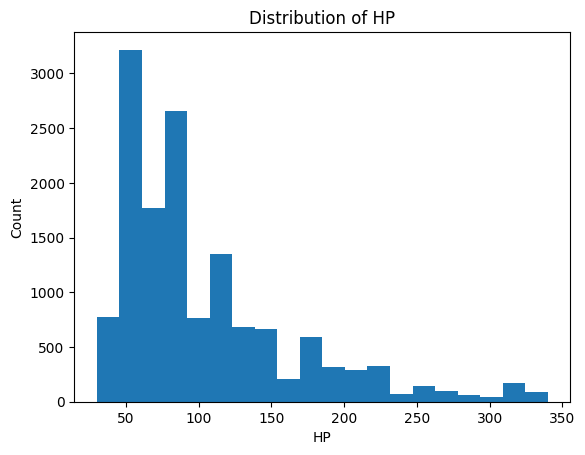

In [ ]:
plt.hist(df["hp"].dropna(), bins=20)
plt.title("Distribution of HP")
plt.xlabel("HP")
plt.ylabel("Count")
plt.show()

⭕️ looks relavent to the price

## Attacks

In [ ]:
df["attacks"][0]

"[{'name': 'Confuse Ray', 'cost': ['Psychic', 'Psychic', 'Psychic'], 'convertedEnergyCost': 3, 'damage': '30', 'text': 'Flip a coin. If heads, the Defending Pokémon is now Confused.'}]"

In [ ]:
def extract_damage_with_symbol(attacks_str):
    if pd.isnull(attacks_str):
        return None
    try:
        attacks = ast.literal_eval(attacks_str)
        if isinstance(attacks, list) and len(attacks) > 0:
            last_attack = attacks[-1]
            damage = last_attack.get('damage', '')
            # Corrected regex pattern here:
            match = re.search(r'(\d+[+x]?)', damage)
            if match:
                return match.group(1)
            else:
                return None
    except Exception as e:
        print(f"Exception: {e}")
        return None

df['last_attack_damage'] = df['attacks'].apply(extract_damage_with_symbol)


In [ ]:
# Null rate
null_rate = df['last_attack_damage'].isnull().mean()
print(f"Null rate is {100*null_rate}%")

Null rate is 11.291337481647206%


🔺 It might be hard to handle with both the ones with symbols and null values

## Weakness

In [ ]:
df["weaknesses"]

0          [{'type': 'Psychic', 'value': '×2'}]
1        [{'type': 'Lightning', 'value': '×2'}]
2         [{'type': 'Fighting', 'value': '×2'}]
3            [{'type': 'Water', 'value': '×2'}]
4         [{'type': 'Fighting', 'value': '×2'}]
                          ...                  
16867         [{'type': 'Fire', 'value': '×2'}]
16868                                       NaN
16875    [{'type': 'Lightning', 'value': '×2'}]
16876        [{'type': 'Metal', 'value': '×2'}]
16877        [{'type': 'Grass', 'value': '×2'}]
Name: weaknesses, Length: 14303, dtype: object

❌ looks irrelevent

## Retreat Cost

In [ ]:
df["retreatCost"]

0        ['Colorless', 'Colorless', 'Colorless']
1        ['Colorless', 'Colorless', 'Colorless']
2                                  ['Colorless']
3        ['Colorless', 'Colorless', 'Colorless']
4                                  ['Colorless']
                          ...                   
16867                 ['Colorless', 'Colorless']
16868                              ['Colorless']
16875                                        NaN
16876                 ['Colorless', 'Colorless']
16877                 ['Colorless', 'Colorless']
Name: retreatCost, Length: 14303, dtype: object

❌You can use convertedRetreatCost

## convertedRetreatCost

In [ ]:
df["convertedRetreatCost"]

0        3.0
1        3.0
2        1.0
3        3.0
4        1.0
        ... 
16867    2.0
16868    1.0
16875    NaN
16876    2.0
16877    2.0
Name: convertedRetreatCost, Length: 14303, dtype: float64

In [ ]:
# Null rate
null_rate = df["convertedRetreatCost"].isnull().mean()
print(f"Null rate is {100*null_rate}%")

Null rate is 5.656156051178074%


## rarity

In [ ]:
# how many sets
print("Number of unique sets:", df['rarity'].nunique())

Number of unique sets: 31


In [ ]:
df['rarity'].value_counts()

rarity
Common                       4130
Uncommon                     2651
Rare                         2208
Rare Holo                    1506
Promo                        1025
Rare Ultra                    523
Rare Holo EX                  315
Rare Holo V                   282
Rare Rainbow                  244
Rare Holo GX                  159
Rare Secret                   150
Rare Shiny                    149
Illustration Rare             122
Rare Holo VMAX                110
Double Rare                    82
Trainer Gallery Rare Holo      80
Ultra Rare                     68
Rare Holo LV.X                 56
Rare Holo VSTAR                44
Rare Shiny GX                  35
Special Illustration Rare      33
Rare BREAK                     27
Rare Prime                     26
Classic Collection             22
Rare Holo Star                 21
LEGEND                         18
Rare Prism Star                16
Rare Shining                   16
Radiant Rare                   15
Hyper R

In [ ]:
rarity_group = {
    # 1. Common
    "Common": "Common",

    # 2. Uncommon
    "Uncommon": "Uncommon",
    "Promo": "Uncommon",
    "Trainer Gallery Rare Holo": "Uncommon",

    # 3. Rare
    "Rare": "Rare",
    "Rare Holo": "Rare",

    # 4. Ultra Rare
    "Rare Ultra": "Ultra Rare",
    "Rare Holo EX": "Ultra Rare",
    "Rare Holo V": "Ultra Rare",
    "Rare Holo GX": "Ultra Rare",

    # 5. VMAX/VSTAR Rare
    "Rare Holo VMAX": "VMAX Rare",
    "Rare Holo VSTAR": "VMAX Rare",

    # 6. Shiny/Radiant Rare
    "Radiant Rare": "Shiny Rare",
    "Rare Shiny": "Shiny Rare",
    "Rare Shiny GX": "Shiny Rare",
    "Rare Shining": "Shiny Rare",

    # 7. Rainbow/Secret Rare
    "Rare Rainbow": "Secret Rare",
    "Rare Secret": "Secret Rare",

    # 8. Elite Rare (high-tier playable/legacy cards)
    "Double Rare": "Elite Rare",
    "Rare BREAK": "Elite Rare",
    "Rare Prime": "Elite Rare",
    "Rare Holo LV.X": "Elite Rare",
    "Rare Holo Star": "Elite Rare",
    "Rare Prism Star": "Elite Rare",

    # 9. Special Illustration / Collection Rare
    "Illustration Rare": "Special Rare",
    "Special Illustration Rare": "Special Rare",
    "Classic Collection": "Special Rare",
    "LEGEND": "Special Rare",
    "Hyper Rare": "Special Rare",
    "Amazing Rare": "Special Rare"
}

df['rarity_grouped'] = df['rarity'].map(rarity_group)

In [ ]:
df["rarity_grouped"].value_counts()

rarity_grouped
Common          4130
Uncommon        3756
Rare            3714
Ultra Rare      1279
Secret Rare      394
Elite Rare       228
Special Rare     216
Shiny Rare       215
VMAX Rare        154
Name: count, dtype: int64

⭕️looks useful

## legalities

In [ ]:
df["legalities"].value_counts()

legalities
{'unlimited': 'Legal', 'expanded': 'Legal'}                         6396
{'unlimited': 'Legal'}                                              4792
{'unlimited': 'Legal', 'standard': 'Legal', 'expanded': 'Legal'}    3096
{'unlimited': 'Legal', 'expanded': 'Banned'}                          13
{'unlimited': 'Banned'}                                                6
Name: count, dtype: int64

❌It is hard to understand what are leagal

## Possible Useful columns

In [ ]:
columns = ["id", "series","generation", "single_type","hp", "last_attack_damage", "convertedRetreatCost","rarity_grouped","market_price","market_price_log"]

In [ ]:
df = df[columns]
df.head()

,id,series,generation,single_type,hp,last_attack_damage,convertedRetreatCost,rarity_grouped,market_price,market_price_log
0,base1-1,Base,First,Psychic,80.0,30,3.0,Rare,60.71,4.122446
1,base1-2,Base,First,Water,100.0,40+,3.0,Rare,163.30,5.101694
2,base1-3,Base,First,Colorless,120.0,80,1.0,Rare,36.44,3.622740
3,base1-4,Base,First,Fire,120.0,100,3.0,Rare,475.08,6.165586
4,base1-5,Base,First,Colorless,40.0,None,1.0,Rare,30.83,3.460409


# Data Cleaning

In [ ]:
df.head()

,id,series,generation,single_type,hp,last_attack_damage,convertedRetreatCost,rarity_grouped,market_price,market_price_log
0,base1-1,Base,First,Psychic,80.0,30,3.0,Rare,60.71,4.122446
1,base1-2,Base,First,Water,100.0,40+,3.0,Rare,163.30,5.101694
2,base1-3,Base,First,Colorless,120.0,80,1.0,Rare,36.44,3.622740
3,base1-4,Base,First,Fire,120.0,100,3.0,Rare,475.08,6.165586
4,base1-5,Base,First,Colorless,40.0,None,1.0,Rare,30.83,3.460409


In [ ]:
df.isna().sum()

id                         0
series                     0
generation                 0
single_type                0
hp                         0
last_attack_damage      1615
convertedRetreatCost     809
rarity_grouped           217
market_price               0
market_price_log           0
dtype: int64

In [ ]:
# You might be able to use last_attack_damage to predict the price but for now we will drop it
df = df.drop(columns=["last_attack_damage"])

In [ ]:
df = df.dropna()
df.isna().sum()

id                      0
series                  0
generation              0
single_type             0
hp                      0
convertedRetreatCost    0
rarity_grouped          0
market_price            0
market_price_log        0
dtype: int64

# Pipeline(Feature Engineering,Train_Test_Split,Modeling and Evaluation)

In [ ]:
df.columns

Index(['id', 'series', 'generation', 'single_type', 'hp',
       'convertedRetreatCost', 'rarity_grouped', 'market_price',
       'market_price_log'],
      dtype='object')

In [ ]:
# Calculate correlation matrix for all numeric columns
correlation_table = df[['hp', 'convertedRetreatCost', 'market_price_log']].corr()

print(correlation_table)

                            hp  convertedRetreatCost  market_price_log
hp                    1.000000              0.492277          0.289539
convertedRetreatCost  0.492277              1.000000          0.149945
market_price_log      0.289539              0.149945          1.000000


In [ ]:
# Pipeline for Machine Learning
X = df.columns.drop(["market_price_log", "market_price_log"]).tolist()
y = ["market_price_log"]

X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.2, random_state=42)

# Identify categorical and numeric columns
categorical_cols = ['series', 'generation','single_type']
numeric_cols = ['hp']# example categorical columns
ordinal_col = ['rarity_grouped']

ordinal_transformer = OrdinalEncoder(categories=[[
    "Common",
    "Uncommon",
    "Rare",
    "Ultra Rare",
    "VMAX Rare",
    "Shiny Rare",
    "Secret Rare",
    "Elite Rare",
    "Special Rare"
]])

# Define preprocessing for categorical data: OneHotEncoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Define preprocessing for numeric data: scaling
numeric_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_col),
        ('num', numeric_transformer, numeric_cols)
    ]
)
# Create the full pipeline including the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit pipeline on training data (this fits preprocessing and the model)
pipeline.fit(X_train, y_train)

# Predict or evaluate on test data (this applies the exact same preprocessing)
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R-squared: 0.6959733607082701


In [ ]:
# Features for the model

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

print(feature_names)

['cat__series_Base' 'cat__series_Black & White'
 'cat__series_Diamond & Pearl' 'cat__series_E-Card' 'cat__series_EX'
 'cat__series_Gym' 'cat__series_HeartGold & SoulSilver' 'cat__series_NP'
 'cat__series_Neo' 'cat__series_Other' 'cat__series_POP'
 'cat__series_Platinum' 'cat__series_Scarlet & Violet'
 'cat__series_Sun & Moon' 'cat__series_Sword & Shield' 'cat__series_XY'
 'cat__generation_Eighth' 'cat__generation_Fifth' 'cat__generation_First'
 'cat__generation_Fourth' 'cat__generation_Fourth '
 'cat__generation_Ninth' 'cat__generation_Second'
 'cat__generation_Seventh' 'cat__generation_Sixth' 'cat__generation_Third'
 'cat__single_type_Colorless' 'cat__single_type_Darkness'
 'cat__single_type_Dragon' 'cat__single_type_Fairy'
 'cat__single_type_Fighting' 'cat__single_type_Fire'
 'cat__single_type_Grass' 'cat__single_type_Lightning'
 'cat__single_type_Metal' 'cat__single_type_Psychic'
 'cat__single_type_Water' 'ord__rarity_grouped' 'num__hp']


# Pipeline(Grid Search)

In [ ]:
param_grid = [
    {
        'regressor': [LinearRegression()],
        'regressor__fit_intercept': [True, False]
    },
    {
        'regressor': [Ridge()],
        'regressor__alpha': [0.1, 1.0, 10.0]
    },
    {
        'regressor': [Lasso()],
        'regressor__alpha': [0.01, 0.1, 1.0]
    },
    {
        'regressor': [ElasticNet()],
        'regressor__alpha': [0.01, 0.1, 1.0],
        'regressor__l1_ratio': [0.2, 0.5, 0.8]
    },
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [50, 100],
        'regressor__max_depth': [None, 10]
    },
    {
        'regressor': [GradientBoostingRegressor(random_state=42)],
        'regressor__n_estimators': [50, 100],
        'regressor__learning_rate': [0.05, 0.1]
    },
    {
        'regressor': [HistGradientBoostingRegressor(random_state=42)],
        'regressor__max_iter': [100, 200]
    },
    {
        'regressor': [AdaBoostRegressor(random_state=42)],
        'regressor__n_estimators': [50, 100]
    },
    {
        'regressor': [SVR()],
        'regressor__kernel': ['linear', 'rbf'],
        'regressor__C': [0.1, 1, 10]
    },
    {
        'regressor': [KNeighborsRegressor()],
        'regressor__n_neighbors': [3, 5, 7]
    },
    {
        'regressor': [DecisionTreeRegressor(random_state=42)],
        'regressor__max_depth': [None, 5, 10]
    },
    {
        'regressor': [DummyRegressor()],
        'regressor__strategy': ['mean', 'median']
    },
    {
        'regressor': [XGBRegressor(random_state=42, verbosity=0)],
        'regressor__n_estimators': [50, 100],
        'regressor__learning_rate': [0.05, 0.1]
    },
    {
        'regressor': [LGBMRegressor(random_state=42)],
        'regressor__n_estimators': [50, 100],
        'regressor__learning_rate': [0.05, 0.1]
    }
]


In [ ]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train.values.ravel())  # Flatten y to 1D if it's a DataFrame

Fitting 5 folds for each of 51 candidates, totalling 255 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 38
[LightGBM] [Info] Start training from score 1.138968
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 38
[LightGBM] [Info] Start training from score 1.144657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wis

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 38
[LightGBM] [Info] Start training from score 1.131137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 39
[LightGBM] [Info] Start training from score 1.126470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 38
[LightGBM] [Info] Start training from score 1.144657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 39
[LightGBM] [Info] Start training from score 1.128731


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 38
[LightGBM] [Info] Start training from score 1.131137


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 39
[LightGBM] [Info] Start training from score 1.126470
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 38
[LightGBM] [Info] Start training from score 1.138968


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 38
[LightGBM] [Info] Start training from score 1.144657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 39
[LightGBM] [Info] Start training from score 1.128731


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 38
[LightGBM] [Info] Start training from score 1.131137


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 39
[LightGBM] [Info] Start training from score 1.126470
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 38
[LightGBM] [Info] Start training from score 1.138968


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 38
[LightGBM] [Info] Start training from score 1.144657
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 39
[LightGBM] [Info] Start training from score 1.128731


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 38
[LightGBM] [Info] Start training from score 1.131137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 8504, number of used features: 39
[LightGBM] [Info] Start training from score 1.126470


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 255.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 10630, number of used features: 39
[LightGBM] [Info] Start training from score 1.133992


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['series',
                                                                          'generation',
                                                                          'single_type']),
                                                                        ('ord',
                                                                         OrdinalEncoder(categories=[['Common',
                                                                                                     'Uncommon',
                                                                                                     'Rare',
                                                                                                     'Ultra '
                                                                                                     'Rare',
                                                                                                     'VMAX '
                                                                                                     'Rare',
                                                                                                     'Shiny '
                                                                                                     'Rare',
                                                                                                     'Secret '
                                                                                                     'Rare',
                                                                                                     'Elite '
                                                                                                     'Rare',
                                                                                                     'Special '
                                                                                                     'Rare']]),
                                                                         ['rarity_grouped']),
                                                                        ('...
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...)],
                          'regressor__learning_rate': [0.05, 0.1],
                          'regressor__n_estimators': [50, 100]},
                         {'regressor': [LGBMRegressor(random_state=42)],
                          'regressor__learning_rate': [0.05, 0.1],
                          'regressor__n_estimators': [50, 100]}],
             scoring='r2', verbose=1)

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best R² score on CV:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
print("Test R² score:", r2_score(y_test, y_pred))

Best parameters: {'regressor': LGBMRegressor(random_state=42), 'regressor__learning_rate': 0.1, 'regressor__n_estimators': 100}
Best R² score on CV: 0.7098409418456193
Test R² score: 0.729524561141103


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# Save the model

In [ ]:
# Save the model
model = joblib.dump(grid_search.best_estimator_, "pokemon_price_model.pkl")

In [ ]:
model = joblib.load("pokemon_price_model.pkl")

# How the model takes an input(Overvalued or Undervalued?)

In [ ]:
# New data just with id
new_data = df[df["id"]=="bw9-119"]
new_data

,id,series,generation,single_type,hp,convertedRetreatCost,rarity_grouped,market_price,market_price_log
6815,bw9-119,Black & White,Fifth,Psychic,100.0,3.0,Secret Rare,104.0,4.65396


In [ ]:
model.predict(new_data)

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


array([5.03703784])

In [ ]:
if new_data["market_price_log"].values[0] > model.predict(new_data):
    print("Overvalued!")
else:
    print("Undervalued!")

Undervalued!


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# How the model takes an input(Recommendation with Budget)

In [ ]:
df["predicted_price"] = np.expm1(model.predict(df[X]))

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# Find the best cards withting the budget
budget = int(input("Enter your budget(EUR):"))
poke_type = input("Enter the type: ")

# Filter by budget and type
filtered_df = df[(df["market_price"] <= budget) & (df["single_type"] == poke_type)]
filtered_df[filtered_df["predicted_price"] == filtered_df["predicted_price"].max()]

,id,series,generation,single_type,hp,convertedRetreatCost,rarity_grouped,market_price,market_price_log,predicted_price
2100,ex3-99,EX,Third,Fire,70.0,1.0,Secret Rare,67.93,4.233091,282.22806
2536,ex7-110,EX,Third,Fire,70.0,1.0,Secret Rare,55.49,4.034064,282.22806


In [ ]:
# Find the best cards withting the budget
budget = int(input("Enter your budget(EUR):"))


# Filter by budget and type
filtered_df = df[(df["market_price"] <= budget)]
filtered_df[filtered_df["predicted_price"] == filtered_df["predicted_price"].max()]

,id,series,generation,single_type,hp,convertedRetreatCost,rarity_grouped,market_price,market_price_log,predicted_price
2880,ex10-116,EX,Third,Darkness,100.0,1.0,Secret Rare,76.74,4.35337,346.689934
